## Imports modules

In [1]:
import numpy as np

# to get and read data
import os
import requests
from zipfile import ZipFile
from scipy.io import arff

# to plot the data
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# for splitting data and evaluating results
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to track progress
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## get and read data

get data

In [2]:
# download zip

if not os.path.exists('CharacterTrajectories.zip'):
    url = 'http://www.timeseriesclassification.com/Downloads/CharacterTrajectories.zip'
    r = requests.get(url, allow_redirects=True)
    open('CharacterTrajectories.zip', 'wb').write(r.content)
    print('zip downloaded')
else:
    print('zip already exists')


# extract folder from zip
if not os.path.exists('CharacterTrajectories'):
    with ZipFile('CharacterTrajectories.zip', 'r') as zipObj:
      # Extract all the contents of zip file in current directory
      zipObj.extractall('CharacterTrajectories')
    print('folder extracted from zip')
else:
    print('zip already extracted')

zip downloaded
folder extracted from zip


read data

In [3]:
# ignoring metadata at index 1, arff -> (data,meta)
train_data = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TRAIN.arff')[0]
test_data = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TEST.arff')[0]

In [4]:
train_inputs, train_labels = list(zip(*train_data))
test_inputs, test_labels = list(zip(*test_data))

# convert to np array
train_inputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in train_inputs])
test_inputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in test_inputs])

# subtract 1 from labels to start indexing from 0
train_labels = np.array(train_labels, dtype=int) - 1
test_labels = np.array(test_labels, dtype=int) - 1

max length = 180


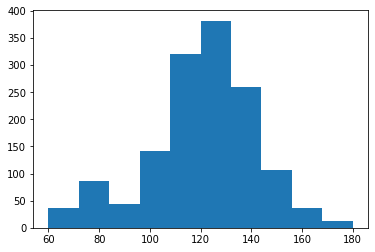

In [5]:
# Distribution of sample lenghts

lengths = []

for input in train_inputs:
  len1 = np.where(np.isnan(input[0]))[0][0]
  lengths.append(len1)

max_len = np.max(lengths)
print('max length =',max_len)
_ = plt.hist(lengths)

preprocess data

In [6]:
def preprocess(inputs):
  inputs1 = []
  for sample in inputs:    
    channels = []
    for channel in sample:
      values = []
      indicator = []

      for value in channel[:max_len]:
        if np.isnan(value):
          # replace nan with 0
          values.append(0)
          indicator.append(0)
        else:
          values.append(value)
          indicator.append(1)

      channels.append(values)
    channels.append(indicator)

    inputs1.append(channels)
    
  inputs1 = np.array(inputs1)  
  return inputs1

In [7]:
train_inputs = preprocess(train_inputs)
test_inputs = preprocess(test_inputs)

classes = ['a','b','c','d','e','g','h','l','m','n','o','p','q','r','s','u','v','w','y','z']
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_inputs),'samples')
print('test data contains',len(test_inputs),'samples')

print('\neach sample has 3 channels : x,y and force')
print('length of each channel is',max_len)
print('nan values have been replaced by 0')
print("a 4th channel has been added to indicate nan")

number of classes : 20

train data contains 1422 samples
test data contains 1436 samples

each sample has 3 channels : x,y and force
length of each channel is 180
nan values have been replaced by 0
a 4th channel has been added to indicate nan


function to plot char

In [8]:
def plot_charVector(char):

    fig, axs = plt.subplots(1,2,figsize=(10,5))
    
    xVel  = char[0]
    yVel  = char[1]
    force = char[2]
    
    xPos  = np.cumsum(xVel)
    yPos  = np.cumsum(yVel)
    #remove last element and insert 0 to the beginning
    xPos  = np.insert(xPos[:-1],0,0)
    yPos  = np.insert(yPos[:-1],0,0)    
    
    #normalize force between 0 and 1
    color = (force - np.min(force)) / (np.max(force)-np.min(force))
    #define color based on force
    colormap = cm.inferno
    
    axs[0].quiver( xPos,yPos, xVel,yVel, color=colormap(color) )
    axs[1].plot(xPos,yPos,'o')
    
    plt.show()

visualize one character of each class

a


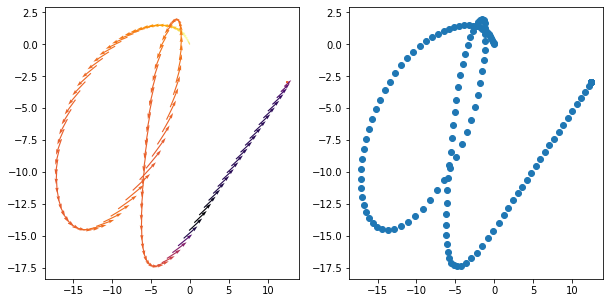

b


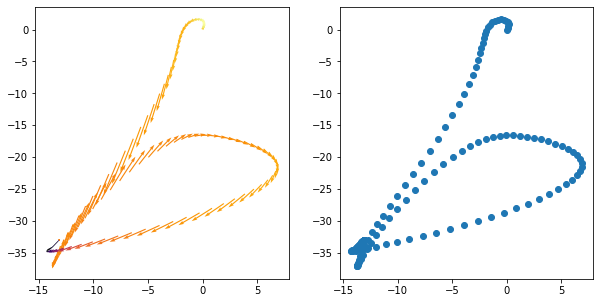

c


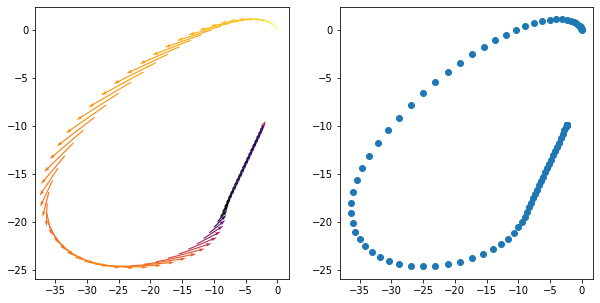

d


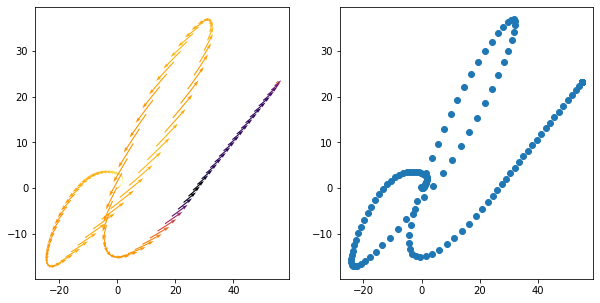

e


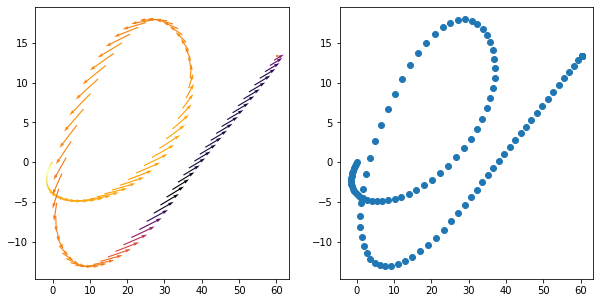

g


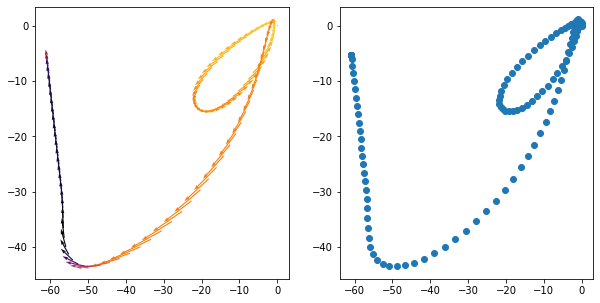

h


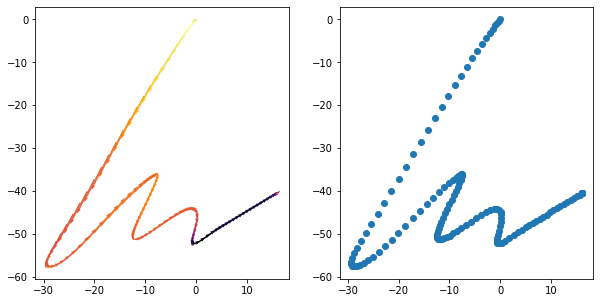

l


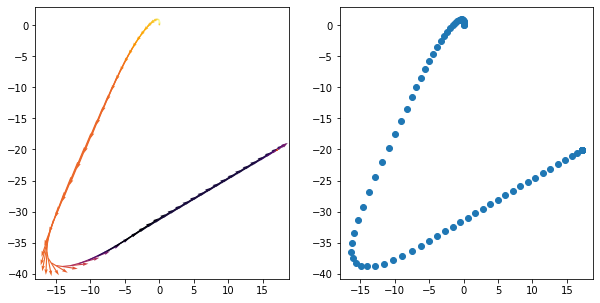

m


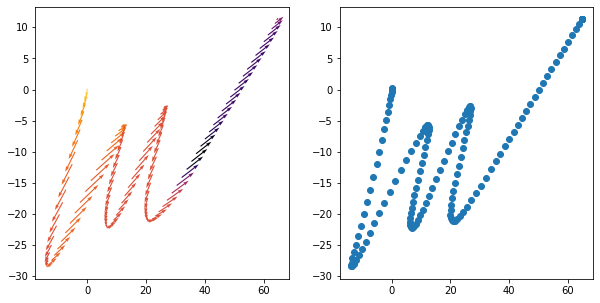

n


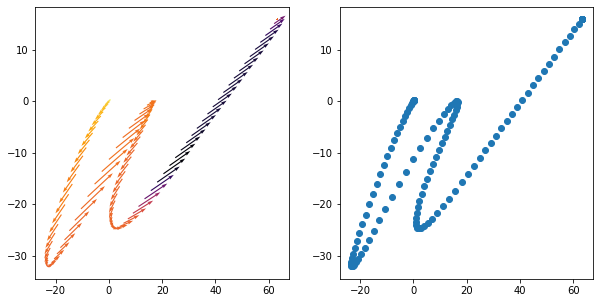

o


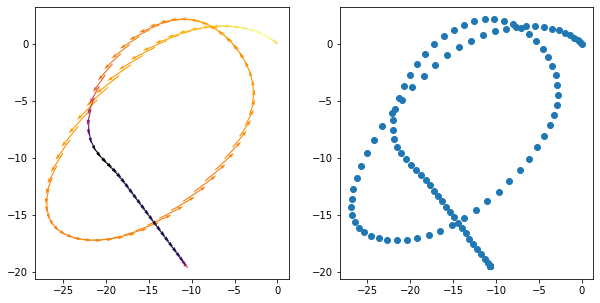

p


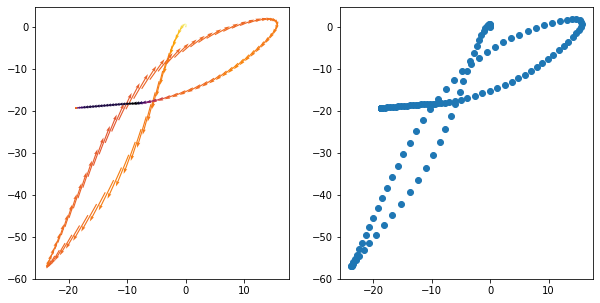

q


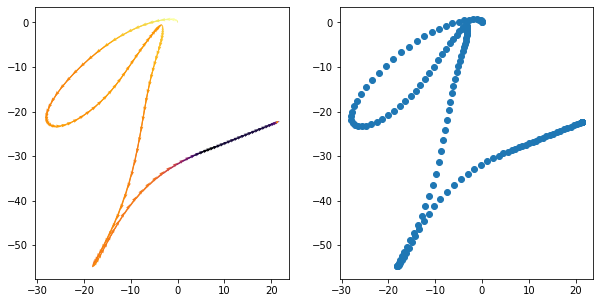

r


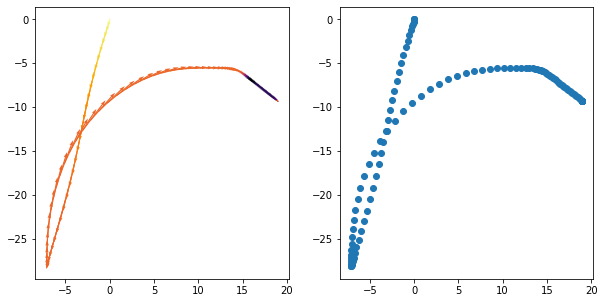

s


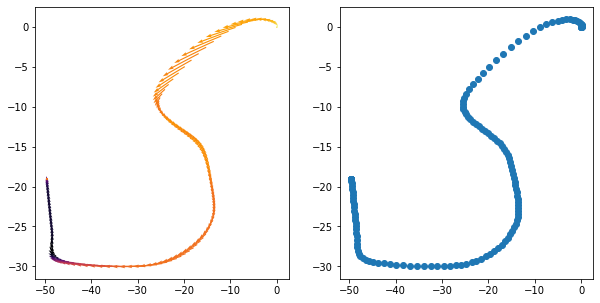

u


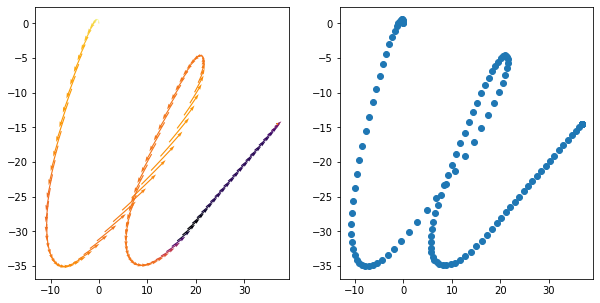

v


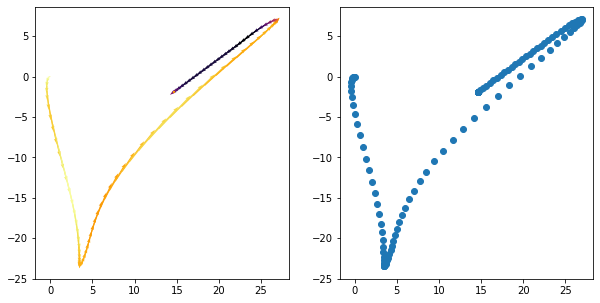

w


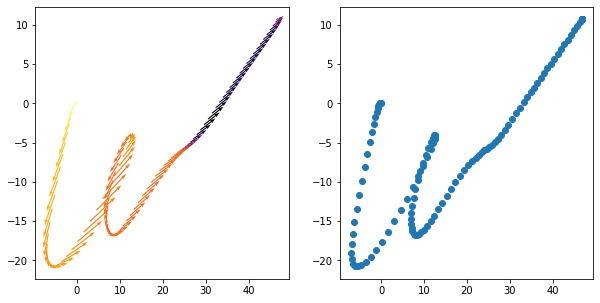

y


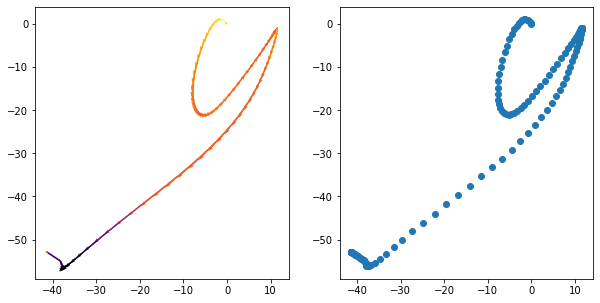

z


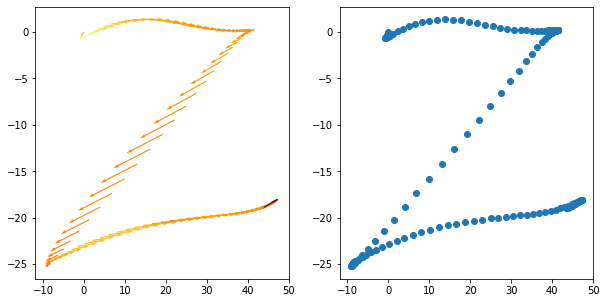

In [9]:
for i,class1 in enumerate(classes):
  indexes = np.where(train_labels==i)[0]
  np.random.seed(0)
  random_index = np.random.choice(indexes)
  print(class1)
  plot_charVector(train_inputs[random_index])

create dataset and dataloader

In [10]:
class mydataset(Dataset):
  def __init__(self, inputs, labels):
    self.inputs = inputs
    self.labels = labels

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.inputs[index]
    label = self.labels[index]
    return input,label


train_inputs, val_inputs, train_labels, val_labels, = train_test_split(train_inputs, train_labels, test_size=0.25, random_state=0)

train_dataset = mydataset(train_inputs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset = mydataset(val_inputs, val_labels)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

test_dataset = mydataset(test_inputs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

## define the network

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(688, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [12]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


Train the network



epoch: 20, train loss: 2.932, val loss: 2.943
epoch: 40, train loss: 0.865, val loss: 0.941
epoch: 60, train loss: 0.241, val loss: 0.339
epoch: 80, train loss: 0.126, val loss: 0.249
epoch: 100, train loss: 0.068, val loss: 0.219
epoch: 120, train loss: 0.043, val loss: 0.237
epoch: 140, train loss: 0.028, val loss: 0.198
epoch: 160, train loss: 0.022, val loss: 0.229

Finished Training


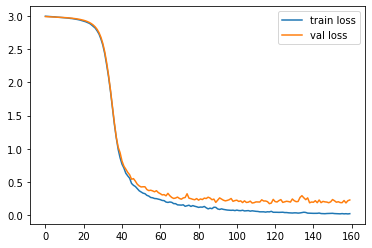

In [13]:

batch_avgTrainLoss = []
batch_avgValLoss = []

for epoch in tqdm(range(160)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []
    
    net.train()
    for i, (inputBatch,labelBatch) in enumerate(train_loader):
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss.append(loss.item())
    
    net.eval()
    for i, (inputBatch,labelBatch) in enumerate(val_loader):
      with torch.no_grad():
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        val_loss.append(loss.item())    
        
    avg_trainLoss = sum(train_loss) / len(train_loss)
    avg_valLoss = sum(val_loss) / len(val_loss)
    batch_avgTrainLoss.append(avg_trainLoss)
    batch_avgValLoss.append(avg_valLoss)

    # print statistics
    if epoch % 20 == 19:
      print('epoch: %d, train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss))

print('Finished Training')
plt.plot(batch_avgTrainLoss, label='train loss')
plt.plot(batch_avgValLoss, label='val loss')
plt.legend()

evaluate

In [26]:
def evaluate(data_loader):
  y_true= []
  y_pred = []
  net.eval()

  for _, (inputBatch,labelBatch) in enumerate(data_loader):
    with torch.no_grad():
      inputBatch = inputBatch.float()
      labelBatch = labelBatch.type(torch.LongTensor)
      inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
      outputBatch = net(inputBatch)
      
      for output,label in zip(outputBatch,labelBatch):
        output, label = output.cpu(), label.cpu()
        y_true.append(label)
        pred = np.argmax(output)
        y_pred.append(pred)

  print(classification_report(y_true, y_pred, target_names=classes, digits=4))

In [27]:
print("evaluation results on train data")
evaluate(train_loader)
print("evaluation results on test data")
evaluate(test_loader)

evaluation results on train data
              precision    recall  f1-score   support

           a     0.9394    0.5536    0.6966        56
           b     0.7162    0.8689    0.7852        61
           c     1.0000    1.0000    1.0000        57
           d     0.5914    1.0000    0.7432        55
           e     0.9867    1.0000    0.9933        74
           g     1.0000    0.8913    0.9425        46
           h     0.7917    0.4524    0.5758        42
           l     1.0000    1.0000    1.0000        63
           m     1.0000    0.8431    0.9149        51
           n     0.7258    0.8491    0.7826        53
           o     1.0000    0.8654    0.9278        52
           p     0.4839    0.8182    0.6081        55
           q     0.8980    1.0000    0.9462        44
           r     0.9211    0.8140    0.8642        43
           s     0.9792    1.0000    0.9895        47
           u     0.9600    0.5000    0.6575        48
           v     1.0000    1.0000    1.0000     

## Patches

function to return patch

In [16]:
def patch_sample(sample, window_size=20, stride=10):

  patches = []
  
  input = sample[0][:3]
  label = sample[1]
  n_patches = int((len(input[0]) - window_size)/stride + 1)

  for i in range(n_patches):

    channels = []
    start = stride*i
    end   = stride*i + window_size

    for channel in input:
      values = []
      indicator = []
      for i in range(max_len):
        if (i in range(start,end)) and not (np.isnan(channel[i])):
          values.append(channel[i])
          indicator.append(1)
        else:
          values.append(0)
          indicator.append(0)
      channels.append(values)

    channels.append(indicator)
    patches.append((channels,label))

  return patches

In [17]:
def patch_dataset(data):
  data1 = []
  for sample in data:
    data1.append(patch_sample(sample))
  data1 = [patch for patches in data1 for patch in patches]
  return data1

In [18]:
train_patchData = patch_dataset(train_data)
test_patchData = patch_dataset(test_data)

In [19]:
train_patchInputs, train_patchLabels = list(zip(*train_patchData))
test_patchInputs, test_patchLabels = list(zip(*test_patchData))

# convert to np array
train_patchInputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in train_patchInputs])
test_patchInputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in test_patchInputs])

# subtract 1 from labels to start indexing from 0
train_patchLabels = np.array(train_patchLabels, dtype=int) - 1
test_patchLabels = np.array(test_patchLabels, dtype=int) - 1

In [20]:
train_patchInputs, val_patchInputs, train_patchLabels, val_patchLabels, = train_test_split(train_patchInputs, train_patchLabels, test_size=0.25, random_state=0)

train_patchDataset = mydataset(train_patchInputs, train_patchLabels)
train_patchLoader = DataLoader(train_patchDataset, batch_size=50, shuffle=True)

val_patchDataset = mydataset(val_patchInputs, val_patchLabels)
val_patchLoader = DataLoader(val_patchDataset, batch_size=50, shuffle=False)

test_patchDataset = mydataset(test_patchInputs, test_patchLabels)
test_patchLoader = DataLoader(test_patchDataset, batch_size=50, shuffle=False)

In [21]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epoch: 20, train loss: 2.449, val loss: 2.430
epoch: 40, train loss: 1.551, val loss: 1.593
epoch: 60, train loss: 1.374, val loss: 1.504
epoch: 80, train loss: 1.280, val loss: 1.458
epoch: 100, train loss: 1.216, val loss: 1.421

Finished Training


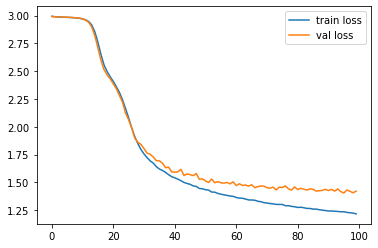

In [22]:
batch_avgTrainLoss = []
batch_avgValLoss = []

for epoch in tqdm(range(100)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []
    
    net.train()
    for i, (inputBatch,labelBatch) in enumerate(train_patchLoader):
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss.append(loss.item())
    
    net.eval()
    for i, (inputBatch,labelBatch) in enumerate(val_patchLoader):
      with torch.no_grad():
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        val_loss.append(loss.item())    
        
    avg_trainLoss = sum(train_loss) / len(train_loss)
    avg_valLoss = sum(val_loss) / len(val_loss)
    batch_avgTrainLoss.append(avg_trainLoss)
    batch_avgValLoss.append(avg_valLoss)

    # print statistics
    if epoch % 20 == 19:
      print('epoch: %d, train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss))

print('Finished Training')
plt.plot(batch_avgTrainLoss, label='train loss')
plt.plot(batch_avgValLoss, label='val loss')
plt.legend()

In [23]:
print("evaluation results on train data")
evaluate(train_patchLoader)
print("evaluation results on test data")
evaluate(test_patchLoader)

evaluation results on train data
              precision    recall  f1-score   support

           a     0.7796    0.6304    0.6971      1066
           b     0.6789    0.6005    0.6373       866
           c     0.8373    0.4883    0.6168       938
           d     0.7677    0.6663    0.7134       992
           e     0.8762    0.6134    0.7216      1177
           g     0.7048    0.5651    0.6273       883
           h     0.6681    0.3965    0.4976       792
           l     0.8281    0.4232    0.5602      1127
           m     0.8569    0.7096    0.7763       785
           n     0.6721    0.5024    0.5750       824
           o     0.7373    0.6022    0.6630       890
           p     0.6976    0.5884    0.6384       831
           q     0.8288    0.7004    0.7592       781
           r     0.6933    0.4967    0.5787       751
           s     0.9394    0.6064    0.7371       869
           u     0.7030    0.4686    0.5624       813
           v     0.1760    0.9848    0.2987     